# DMD analysis of a slice extracted from a 3D simulation

In [1]:
from os import makedirs
import numpy as np
import torch as pt
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from stl import mesh
from flowtorch.data import HDF5Dataloader, mask_box
from flowtorch.analysis import SVD, DMD

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

output = "./output/naca0012_analysis/"
makedirs(output, exist_ok=True)

In [2]:
Ma = 0.75
U_inf = 255.22
a_inf = U_inf / Ma
rho_inf = 1.19058
chord = 0.6010500

def normalize_frequency(f):
    return 2*np.pi*chord*f/U_inf

In [3]:
def add_naca0012_patch(axis, scale=1.0):
    x_up = naca_stl.x[naca_stl.y > 0] * scale
    y_up = naca_stl.y[naca_stl.y > 0] * scale
    x_low = naca_stl.x[naca_stl.y < 0] * scale
    y_low = naca_stl.y[naca_stl.y < 0] * scale
    axis.fill_between(x_up, 0.0, y_up, color="k")
    axis.fill_between(x_low, y_low, 0.0, color="k")
    
naca_stl = mesh.Mesh.from_file("../geometry/naca0012.stl")

In [4]:
path = "/media/andre/Elements/naca0012_shock_buffet/run/rhoCF_set1_alpha4_saiddes_ref0_z25/flowtorch.hdf5"
loader = HDF5Dataloader(path)
print(loader.field_names[loader.write_times[0]])
print(loader.write_times[0], loader.write_times[-1])

['Ma', 'T', 'U', 'p', 'rho']
0.0326 0.1015


In [5]:
times = pt.tensor([float(t) for t in loader.write_times])
times = times - times[0]
dtimes = times * a_inf / chord
vertices = loader.vertices / chord
vol = loader.weights

In [6]:
# extract plane from middle (in spanwise direction - z)
zmin, zmax = 0.0024042/chord, 0.0072126/chord
mask = mask_box(vertices, [-0.2, -0.3, zmin], [3, 1, zmax])
n_points = mask.sum().item()
n_points

71613

In [7]:
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)
volsq = pt.masked_select(vol, mask).sqrt()

In [8]:
# density
rdm = pt.load("./output/naca0012_data/rdm_slice.pt")
# x and y velocity components
vdm = pt.load("./output/naca0012_data/vdm_slice.pt")
# velocity and speed of sound
avdm = pt.load("./output/naca0012_data/avdm_slice.pt")

## SVD analysis

### Weighted vs. unweighted state vector

In [9]:
rsvd = SVD(rdm, rank=1000)
print(rsvd)
wrsvd = SVD(rdm*volsq.unsqueeze(-1), rank=1000)
print(wrsvd)

SVD of a 71613x690 data matrix
Selected/optimal rank: 690/286
data type: torch.float32 (4b)
truncated SVD size: 190.3143Mb
SVD of a 71613x690 data matrix
Selected/optimal rank: 690/289
data type: torch.float32 (4b)
truncated SVD size: 190.3143Mb


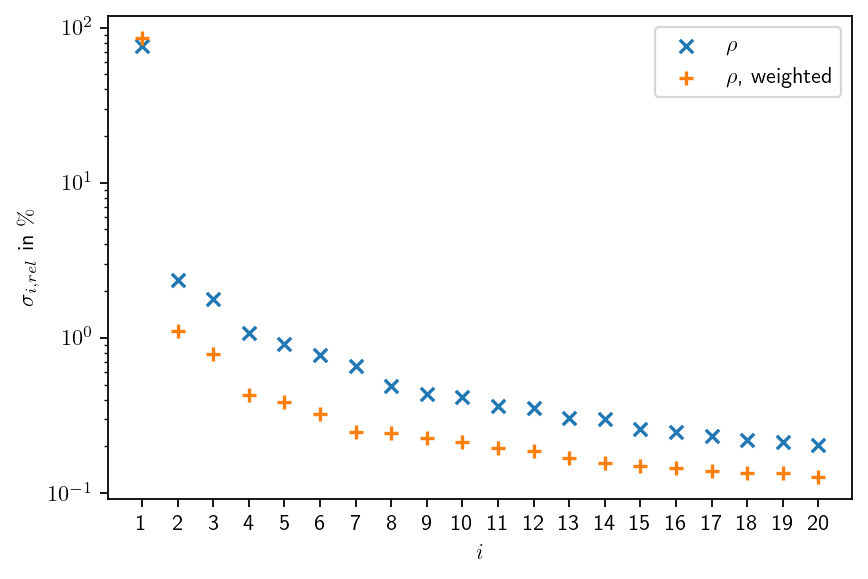

In [10]:
n_show = 20
plt.scatter(range(1, n_show+1), rsvd.s_rel[:n_show], marker="x", label=r"$\rho$")
plt.scatter(range(1, n_show+1), wrsvd.s_rel[:n_show], marker="+", label=r"$\rho$, weighted")
plt.legend()
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,rel}$ in $\%$")
plt.gca().set_xticks(range(1, n_show+1))
plt.gca().set_xticklabels(range(1, n_show+1))
plt.yscale("log")
plt.show()

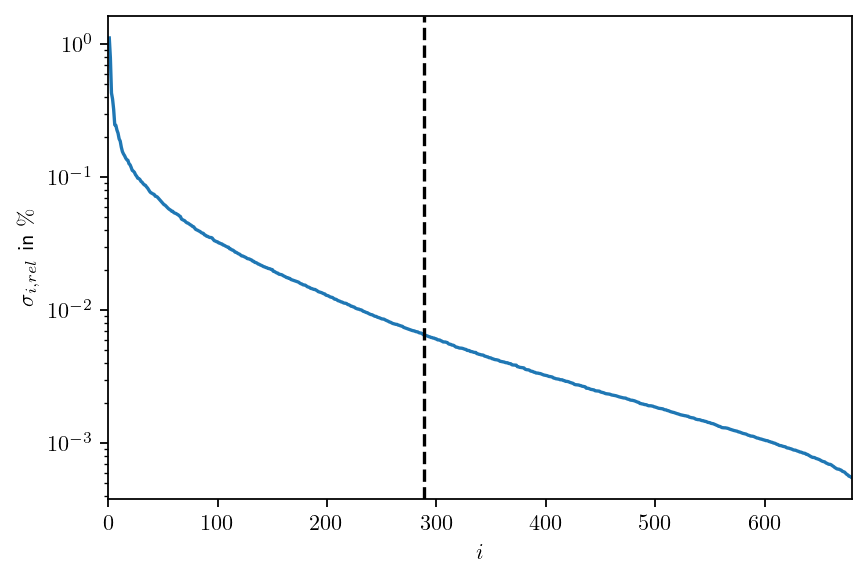

In [84]:
n_show = 680
plt.plot(range(1, n_show), wrsvd.s_rel[1:n_show])
plt.axvline(wrsvd.opt_rank, ls="--", c="k")
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,rel}$ in $\%$")
plt.yscale("log")
plt.xlim(0, n_show)
plt.savefig(output + "naca_dmd_slice_htsvd.svg", bbox_inches="tight")
plt.show()

Cumulative variance using 342 modes: 99.00
Cumulative variance using 285 modes: 99.00


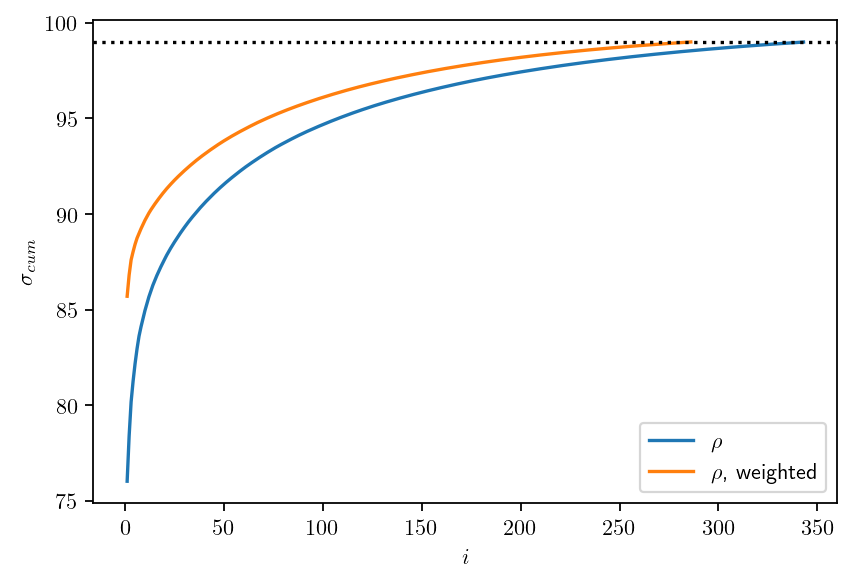

In [11]:
i99_r = pt.argmin((rsvd.s_cum - 99.0).abs()).item()
i99_wr = pt.argmin((wrsvd.s_cum - 99.0).abs()).item()
print(f"Cumulative variance using {i99_r:d} modes: {rsvd.s_cum[i99_r]:2.2f}")
print(f"Cumulative variance using {i99_wr:d} modes: {wrsvd.s_cum[i99_wr]:2.2f}")
plt.plot(range(1, i99_r+2), rsvd.s_cum[:i99_r+1], label=r"$\rho$")
plt.plot(range(1, i99_wr+2), wrsvd.s_cum[:i99_wr+1], label=r"$\rho$, weighted")
plt.axhline(99, ls=":", c="k")
plt.xlabel("$i$")
plt.ylabel(r"$\sigma_{cum}$")
plt.legend()
plt.show()

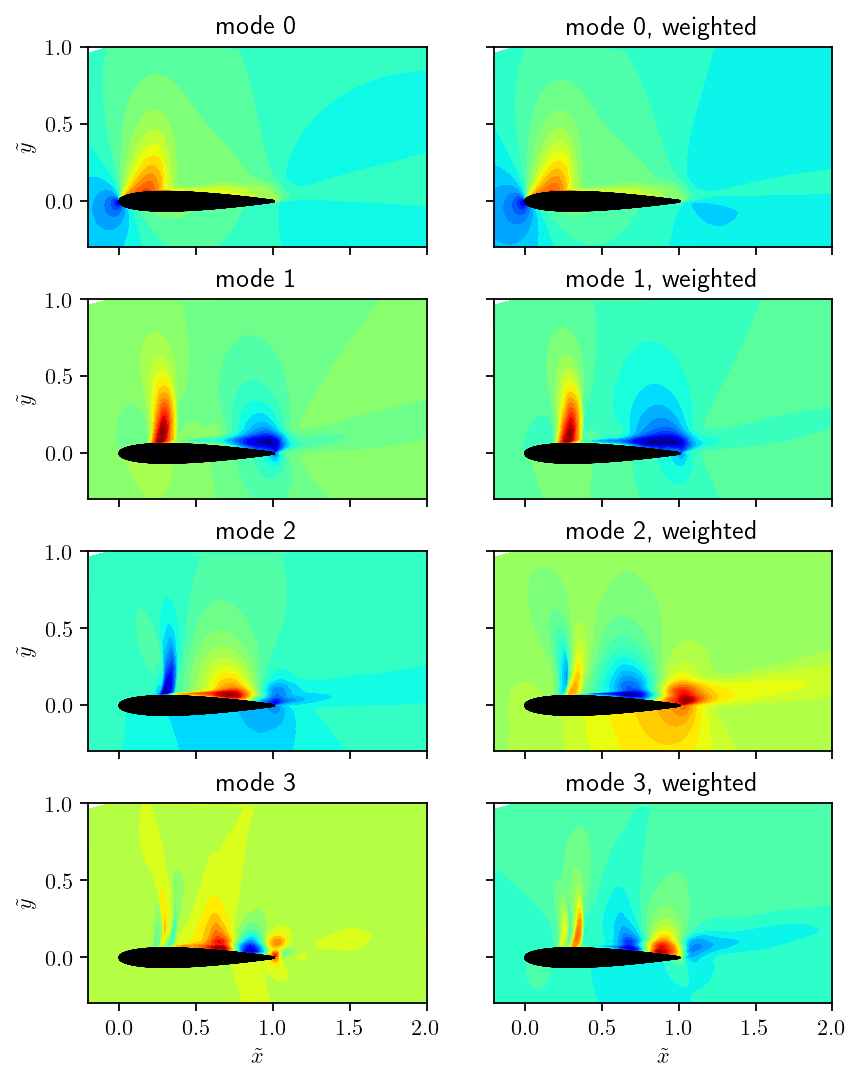

In [12]:
n_modes = 4
fig, axarr = plt.subplots(n_modes, 2, figsize=(6, 2*n_modes), sharex=True, sharey=True)

for i in range(n_modes):
    axarr[i, 0].tricontourf(x, y, rsvd.U[:, i], levels=30, cmap="jet")
    axarr[i, 1].tricontourf(x, y, wrsvd.U[:, i]/volsq, levels=30, cmap="jet")
    axarr[i, 0].set_title(f"mode {i}")
    axarr[i, 1].set_title(f"mode {i}, weighted")
    axarr[i, 0].set_ylabel(r"$\tilde{y}$")
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
        add_naca0012_patch(ax)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

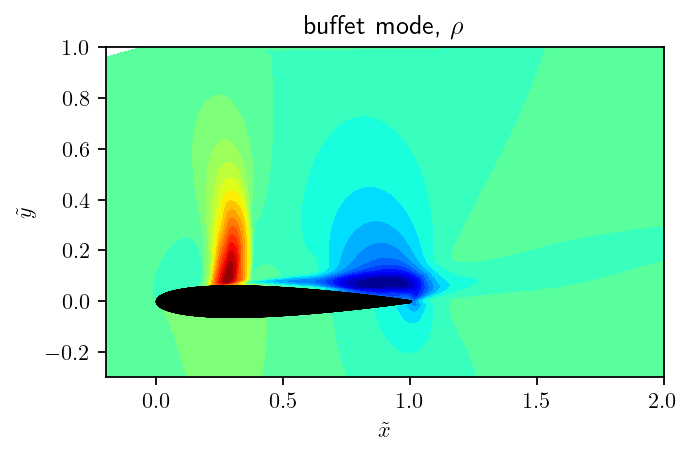

In [17]:
fig, ax = plt.subplots( figsize=(4.5, 3))

ax.tricontourf(x, y, wrsvd.U[:, 1]/volsq, levels=30, cmap="jet")
ax.set_title(r"buffet mode, $\rho$")
ax.set_xlabel(r"$\tilde{x}$")
ax.set_ylabel(r"$\tilde{y}$")
ax.set_aspect("equal")
ax.set_xlim(-0.2, 2.0)
ax.set_ylim(-0.3, 1.0)
add_naca0012_patch(ax)

plt.savefig(output + "naca_svd_slice_buffet_mode.svg", bbox_inches="tight")
plt.savefig(output + "naca_svd_slice_buffet_mode.png", bbox_inches="tight")
plt.savefig(output + "naca_svd_slice_buffet_mode.pdf", bbox_inches="tight")

plt.show()

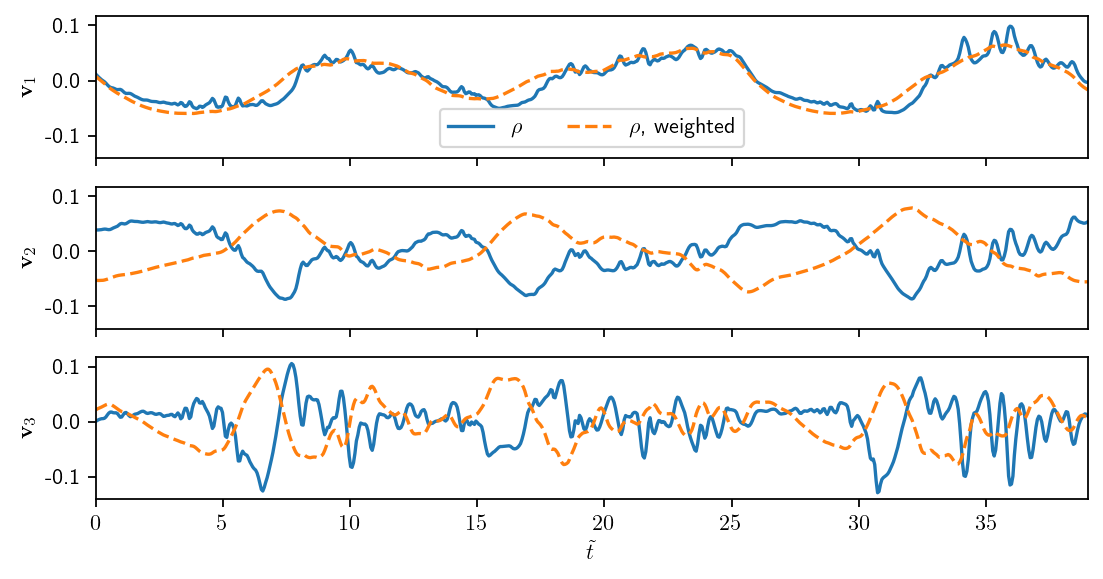

In [70]:
fig, axarr = plt.subplots(3, figsize=(8, 4), sharex=True, sharey=True)

for i in range(0, 3):
    axarr[i].plot(dtimes, rsvd.V[:, i+1], ls="-", label=r"$\rho$")
    axarr[i].plot(dtimes, wrsvd.V[:, i+1], ls="--", label=r"$\rho$, weighted")
    axarr[i].set_ylabel(r"$\mathbf{{ v }}_{:d}$".format(i+1))
    
axarr[0].set_xlim(0, dtimes[-1])
axarr[-1].set_xlabel(r"$\tilde{t}$")
axarr[0].legend(ncol=2)
axarr[0].set_yticks([-0.1, 0.0, 0.1])
axarr[0].set_yticklabels([-0.1, 0.0, 0.1])

plt.savefig(output + "naca_svd_slice_coeffs.svg", bbox_inches="tight")
plt.savefig(output + "naca_svd_slice_coeffs.png", bbox_inches="tight")
plt.savefig(output + "naca_svd_slice_coeffs.pdf", bbox_inches="tight")

plt.show()

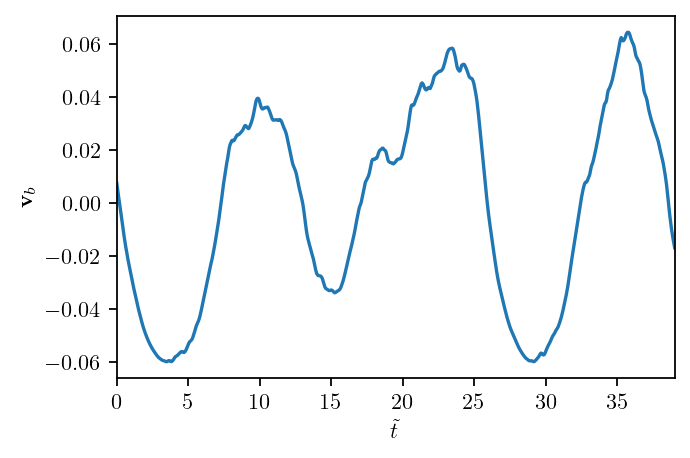

In [23]:
fig, ax = plt.subplots(figsize=(4.5, 3))
ax.plot(dtimes, wrsvd.V[:, 1], ls="-")
ax.set_xlim(0, dtimes[-1])
ax.set_xlabel(r"$\tilde{t}$")
ax.set_ylabel(r"$\mathbf{v}_b$")

plt.savefig(output + "naca_svd_slice_buffet_coeff.svg", bbox_inches="tight")
plt.savefig(output + "naca_svd_slice_buffet_coeff.png", bbox_inches="tight")
plt.savefig(output + "naca_svd_slice_buffet_coeff.pdf", bbox_inches="tight")

plt.show()

In [24]:
dt = (times[1] - times[0]).item()
n_samples = times.shape[0]

for i in range(5):
    f, a = welch(rsvd.V[:, i].numpy(), fs=1/dt, nperseg=n_samples, nfft=n_samples)
    amax = np.argmax(a),
    print(f"mode {i}:", f[amax], normalize_frequency(f[amax]), a[amax])
    f, a = welch(wrsvd.V[:, i].numpy(), fs=1/dt, nperseg=n_samples, nfft=n_samples)
    amax = np.argmax(a)
    print(f"mode {i}, weighted:", f[amax], normalize_frequency(f[amax]), a[amax])
    print("-"*20)

mode 0: 43.479144591173466 0.6433640011636467 3.2763618e-09
mode 0, weighted: 43.479144591173466 0.6433640011636467 1.109851e-10
--------------------
mode 1: 43.479144591173466 0.6433640011636467 4.400674e-05
mode 1, weighted: 43.479144591173466 0.6433640011636467 4.2278407e-05
--------------------
mode 2: 43.479144591173466 0.6433640011636467 2.5399608e-05
mode 2, weighted: 43.479144591173466 0.6433640011636467 4.163244e-05
--------------------
mode 3: 115.94438557646258 1.7156373364363915 1.06802145e-05
mode 3, weighted: 115.94438557646258 1.7156373364363915 2.6371437e-05
--------------------
mode 4: 43.479144591173466 0.6433640011636467 1.7439012e-05
mode 4, weighted: 86.95828918234693 1.2867280023272933 3.0588853e-05
--------------------


### Comparing different state vectors

In [19]:
vsvd = SVD(vdm, rank=700)
print(vsvd)
avsvd = SVD(avdm, rank=700)
print(avsvd)

SVD of a 143226x690 data matrix
Selected/optimal rank: 690/285
data type: torch.float32 (4b)
truncated SVD size: 378.8099Mb
SVD of a 214839x690 data matrix
Selected/optimal rank: 690/247
data type: torch.float32 (4b)
truncated SVD size: 567.3054Mb


Cumulative variance using 285 modes: 99.00
Cumulative variance using 464 modes: 99.00
Cumulative variance using 543 modes: 99.52


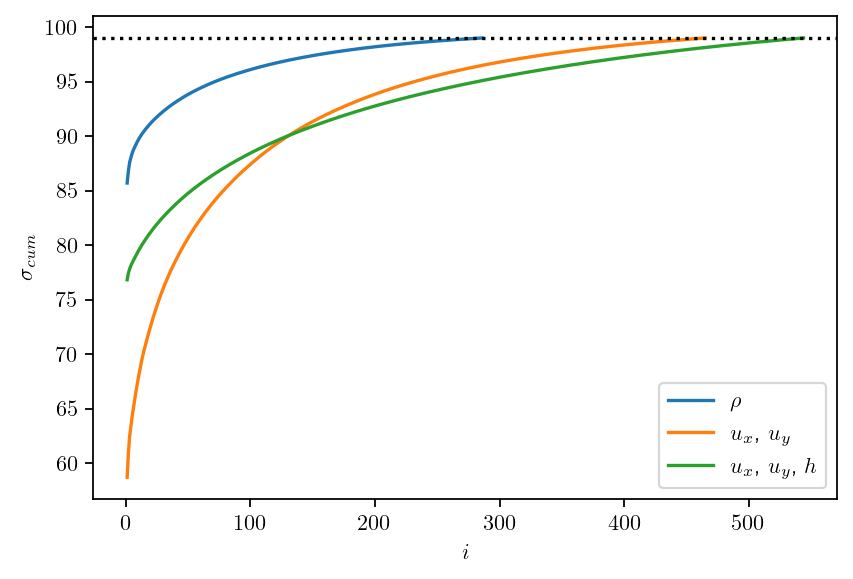

In [21]:
i99_r = pt.argmin((wrsvd.s_cum - 99.0).abs()).item()
i99_v = pt.argmin((vsvd.s_cum - 99.0).abs()).item()
i99_av = pt.argmin((avsvd.s_cum - 99.0).abs()).item()
print(f"Cumulative variance using {i99_r:d} modes: {wrsvd.s_cum[i99_r]:2.2f}")
print(f"Cumulative variance using {i99_v:d} modes: {vsvd.s_cum[i99_v]:2.2f}")
print(f"Cumulative variance using {i99_av:d} modes: {vsvd.s_cum[i99_av]:2.2f}")
plt.plot(range(1, i99_r+2), wrsvd.s_cum[:i99_r+1], label=r"$\rho$")
plt.plot(range(1, i99_v+2), vsvd.s_cum[:i99_v+1], label=r"$u_x$, $u_y$")
plt.plot(range(1, i99_av+2), avsvd.s_cum[:i99_av+1], label=r"$u_x$, $u_y$, $h$")
plt.axhline(99, ls=":", c="k")
plt.xlabel("$i$")
plt.ylabel(r"$\sigma_{cum}$")
plt.legend()
plt.show()

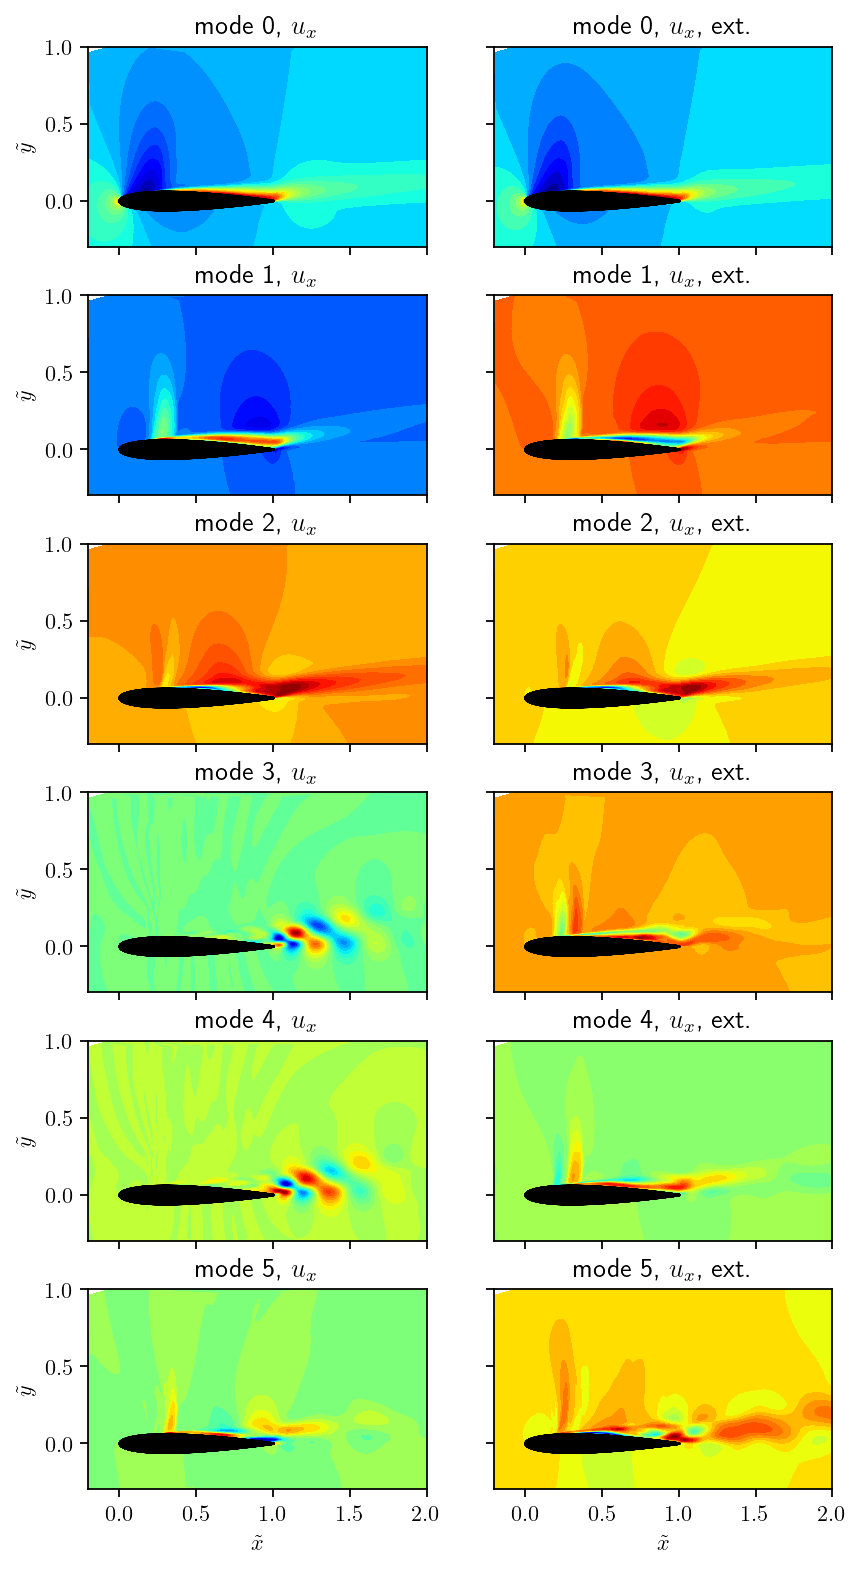

In [22]:
n_modes = 6
fig, axarr = plt.subplots(n_modes, 2, figsize=(6, 2*n_modes), sharex=True, sharey=True)

for i in range(n_modes):
    axarr[i, 0].tricontourf(x, y, vsvd.U[:n_points, i]/volsq, levels=30, cmap="jet")
    axarr[i, 1].tricontourf(x, y, avsvd.U[:n_points, i]/volsq, levels=30, cmap="jet")
    axarr[i, 0].set_title(f"mode {i}" + r", $u_x$")
    axarr[i, 1].set_title(f"mode {i}" + r", $u_x$, ext.")
    axarr[i, 0].set_ylabel(r"$\tilde{y}$")
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
        add_naca0012_patch(ax)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

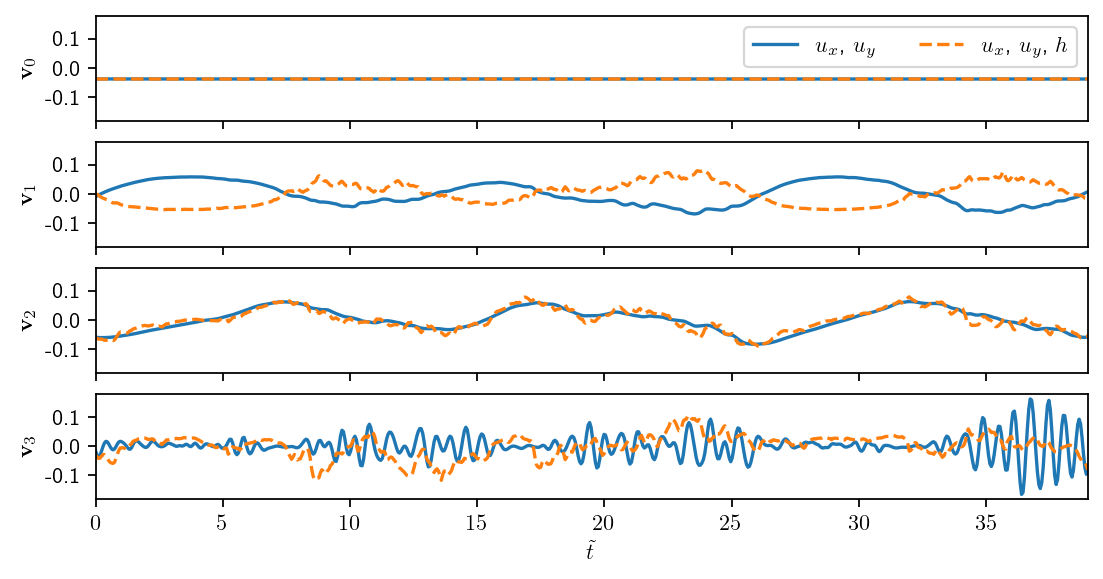

In [26]:
fig, axarr = plt.subplots(4, figsize=(8, 4), sharex=True, sharey=True)

for i in range(4):
    axarr[i].plot(dtimes, vsvd.V[:, i], ls="-", label=r"$u_x$, $u_y$")
    axarr[i].plot(dtimes, avsvd.V[:, i], ls="--", label=r"$u_x$, $u_y$, $h$")
    axarr[i].set_ylabel(r"$\mathbf{{ v }}_{:d}$".format(i))
    
axarr[0].set_xlim(0, dtimes[-1])
axarr[-1].set_xlabel(r"$\tilde{t}$")
axarr[0].legend(ncol=2)
axarr[0].set_yticks([-0.1, 0.0, 0.1])
axarr[0].set_yticklabels([-0.1, 0.0, 0.1])
plt.show()

In [27]:
for i in range(6):
    f, a = welch(vsvd.V[:, i].numpy(), fs=1/dt, nperseg=n_samples, nfft=n_samples)
    amax = np.argmax(a),
    print(f"mode {i}:", f[amax], normalize_frequency(f[amax]), a[amax])
    f, a = welch(avsvd.V[:, i].numpy(), fs=1/dt, nperseg=n_samples, nfft=n_samples)
    amax = np.argmax(a)
    print(f"mode {i}, ext.:", f[amax], normalize_frequency(f[amax]), a[amax])
    print("-"*20)

mode 0: 43.479144591173466 0.6433640011636467 5.4364435e-10
mode 0, ext.: 14.493048197057822 0.21445466705454894 2.4574244e-11
--------------------
mode 1: 43.479144591173466 0.6433640011636467 4.552005e-05
mode 1, ext.: 43.479144591173466 0.6433640011636467 4.357507e-05
--------------------
mode 2: 43.479144591173466 0.6433640011636467 4.463472e-05
mode 2, ext.: 43.479144591173466 0.6433640011636467 4.6491525e-05
--------------------
mode 3: 579.7219278823129 8.578186682181958 5.6741537e-06
mode 3, ext.: 14.493048197057822 0.21445466705454894 3.025331e-05
--------------------
mode 4: 579.7219278823129 8.578186682181958 6.0730836e-06
mode 4, ext.: 72.46524098528911 1.0722733352727447 2.6286223e-05
--------------------
mode 5: 115.94438557646258 1.7156373364363915 1.9962237e-05
mode 5, ext.: 115.94438557646258 1.7156373364363915 1.2847829e-05
--------------------


## DMD analysis

In [30]:
L2_r = []
L2_r_orth = []
L2_v = []
L2_v_orth = []
L2_av = []
L2_av_orth = []

ranks = list(range(50, 701, 50))
dt = (times[1] - times[0]).item()
n_samples = times.shape[0]

for r in ranks:
    print(f"\rr={r}", end="")
    L2_r.append((DMD(rdm*volsq.unsqueeze(-1), dt=dt, rank=r, optimal=True).reconstruction - rdm*volsq.unsqueeze(-1)).norm())
    L2_v.append((DMD(vdm, dt=dt, rank=r, optimal=True).reconstruction - vdm).norm())
    L2_av.append((DMD(avdm, dt=dt, rank=r, optimal=True).reconstruction - avdm).norm())
    L2_r_orth.append((DMD(rdm*volsq.unsqueeze(-1), dt=dt, rank=r, optimal=True, unitary=True).reconstruction - rdm*volsq.unsqueeze(-1)).norm())
    L2_v_orth.append((DMD(vdm, dt=dt, rank=r, optimal=True, unitary=True).reconstruction - vdm).norm())
    L2_av_orth.append((DMD(avdm, dt=dt, rank=r, optimal=True, unitary=True).reconstruction - avdm).norm())

r=700

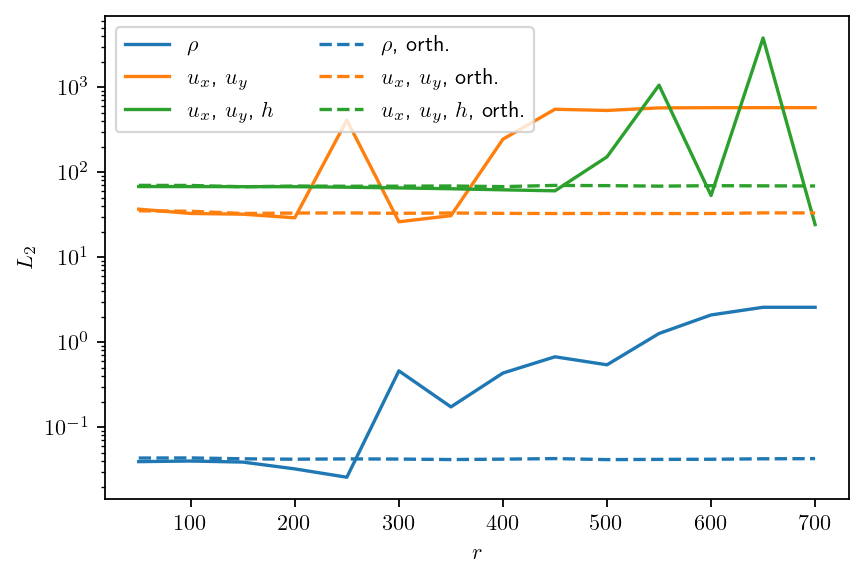

In [36]:
plt.plot(ranks, L2_r, ls="-", c="C0", label=r"$\rho$")
plt.plot(ranks, L2_v, ls="-", c="C1", label=r"$u_x$, $u_y$")
plt.plot(ranks, L2_av, ls="-", c="C2", label=r"$u_x$, $u_y$, $h$")
plt.plot(ranks, L2_r_orth, ls="--", c="C0", label=r"$\rho$, orth.")
plt.plot(ranks, L2_v_orth, ls="--", c="C1", label=r"$u_x$, $u_y$, orth.")
plt.plot(ranks, L2_av_orth, ls="--", c="C2", label=r"$u_x$, $u_y$, $h$, orth.")

plt.legend(ncol=2)
plt.xlabel(r"$r$")
plt.ylabel(r"$L_2$")
plt.yscale("log")
plt.show()

In [27]:
dmd_def1 = DMD(rdm, dt=dt, rank=400)
dmd_def2 = DMD(rdm, dt=dt, rank=500)

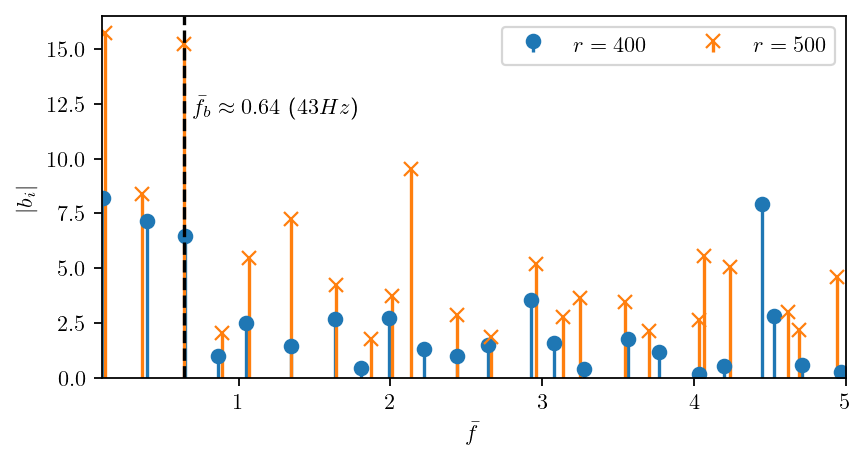

In [31]:
pos1 = dmd_def1.frequency > 1
pos2 = dmd_def2.frequency > 1
imp1 = dmd_def1.amplitude.abs()
imp2 = dmd_def2.amplitude.abs()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(dmd_def1.frequency[pos1].numpy()), imp1[pos1].numpy(), basefmt="none", linefmt="C0-", label=r"$r=400$")
ax.stem(normalize_frequency(dmd_def2.frequency[pos2].numpy()), imp2[pos2].numpy(), basefmt="none", linefmt="C1-", markerfmt="C1x", label=r"$r=500$")
ax.set_xlabel(r"$\bar{f}$")
ax.set_ylabel(r"$|b_i|$")
ax.legend(ncol=2)
ax.set_xlim(0.1, 5)
ax.set_ylim(0)
ax.axvline(0.6433, ls="--", c="k")
ax.text(0.7, 12, r"$\bar{{f}}_{b}\approx 0.64$ ($43Hz$)")

plt.savefig(output + "naca_dmd_slice_freq_def.svg", bbox_inches="tight")
plt.savefig(output + "naca_dmd_slice_freq_def.png", bbox_inches="tight")
plt.savefig(output + "naca_dmd_slice_freq_def.pdf", bbox_inches="tight")

plt.show()

In [37]:
rdmd = DMD(rdm*volsq.unsqueeze(-1), dt=dt, optimal=True)
print(rdmd)
vdmd = DMD(vdm, dt=dt, optimal=True)
print(vdmd)
avdmd = DMD(avdm, dt=dt, optimal=True)
print(avdmd)

SVD:
SVD of a 71613x289 data matrix
Selected/optimal rank: 289/289
data type: torch.float32 (4b)
truncated SVD size: 79.7103Mb
LSQ:
Overall DMD size: 238.2488Mb
SVD:
SVD of a 143226x285 data matrix
Selected/optimal rank: 285/285
data type: torch.float32 (4b)
truncated SVD size: 156.4639Mb
LSQ:
Overall DMD size: 468.5131Mb
SVD:
SVD of a 214839x247 data matrix
Selected/optimal rank: 247/247
data type: torch.float32 (4b)
truncated SVD size: 203.0779Mb
LSQ:
Overall DMD size: 608.4009Mb


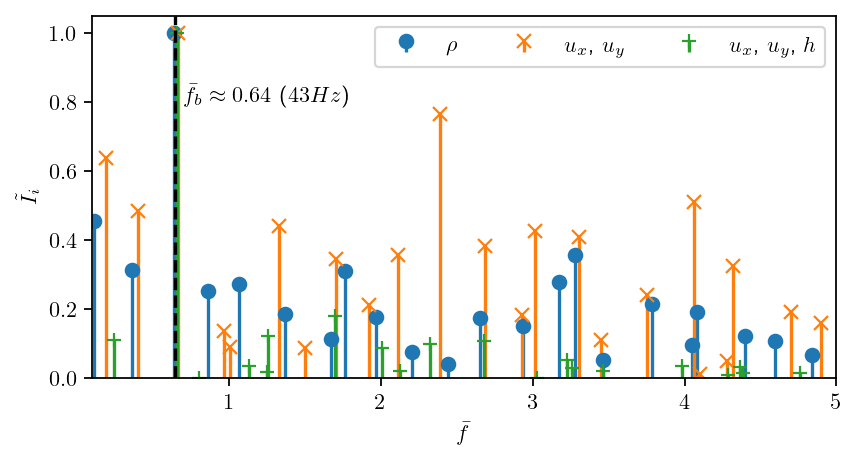

In [106]:
rpos = rdmd.frequency > 1
vpos = vdmd.frequency > 1
avpos = avdmd.frequency > 1
rimp = rdmd.integral_contribution / rdmd.integral_contribution[rpos].max()
vimp = vdmd.integral_contribution / vdmd.integral_contribution[vpos].max()
avimp = avdmd.integral_contribution / avdmd.integral_contribution[avpos].max()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(rdmd.frequency[rpos].numpy()), rimp[rpos].numpy(), basefmt="none", linefmt="C0-", label=r"$\rho$")
ax.stem(normalize_frequency(vdmd.frequency[vpos].numpy()), vimp[vpos].numpy(), basefmt="none", linefmt="C1-", markerfmt="C1x", label=r"$u_x$, $u_y$")
ax.stem(normalize_frequency(avdmd.frequency[avpos].numpy()), avimp[avpos].numpy(), basefmt="none", linefmt="C2-", markerfmt="C2+", label=r"$u_x$, $u_y$, $h$")
ax.set_xlabel(r"$\bar{f}$")
ax.set_ylabel(r"$\tilde{I}_i$")
ax.legend(ncol=3)
ax.set_xlim(0.1, 5)
ax.set_ylim(0)
ax.axvline(0.6433, ls="--", c="k")
ax.text(0.7, 0.8, r"$\bar{{f}}_{b}\approx 0.64$ ($43Hz$)")

plt.savefig(output + "naca_dmd_slice_freq.svg", bbox_inches="tight")
plt.savefig(output + "naca_dmd_slice_freq.png", bbox_inches="tight")
plt.savefig(output + "naca_dmd_slice_freq.pdf", bbox_inches="tight")

plt.show()

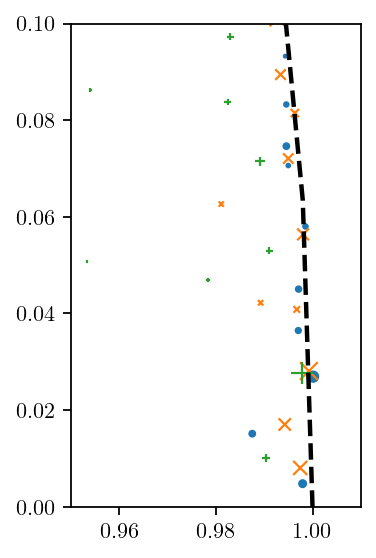

In [49]:
t = pt.linspace(0, 2 * np.pi, 100)
plt.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
plt.scatter(rdmd.eigvals.real[rpos], rdmd.eigvals.imag[rpos], s=20*rdmd.integral_contribution[rpos], marker="o", c="C0", lw=1)
plt.scatter(vdmd.eigvals.real[vpos], vdmd.eigvals.imag[vpos], s=0.2*vdmd.integral_contribution[vpos], marker="x", c="C1", lw=1)
plt.scatter(avdmd.eigvals.real[avpos], avdmd.eigvals.imag[avpos], s=0.2*avdmd.integral_contribution[avpos], marker="+", c="C2", lw=1)
plt.gca().set_aspect("equal")
plt.xlim(0.95, 1.01)
plt.ylim(0.0, 0.1)

plt.show()

In [105]:
for dmd in (rdmd, vdmd, avdmd):
    top_k = dmd.top_modes(30, integral=True)
    for k in top_k:
        print(k.item(), dmd.frequency[k].item(), dmd.frequency[k].item()/43.0, normalize_frequency(dmd.frequency[k]/43.0).item(), dmd.eigvals[k].abs().item())
    print("-"*20)

246 0.0 0.0 0.0 0.9999810457229614
269 42.849327087402344 0.9964959787767987 0.01474522240459919 1.0004782676696777
270 -42.849327087402344 -0.9964959787767987 -0.01474522240459919 1.0004782676696777
248 -7.618511199951172 -0.1771746790686319 -0.002621666295453906 0.9979649782180786
247 7.618511199951172 0.1771746790686319 0.002621666295453906 0.9979649782180786
263 221.3421173095703 5.147491100222566 0.07616779208183289 0.9990405440330505
264 -221.3421173095703 -5.147491100222566 -0.07616779208183289 0.9990405440330505
250 -24.377037048339844 -0.5669078383334848 -0.008388576097786427 0.9876474142074585
249 24.377037048339844 0.5669078383334848 0.008388576097786427 0.9876474142074585
288 -119.20465087890625 -2.772201183230378 -0.041020460426807404 0.9973811507225037
287 119.20465087890625 2.772201183230378 0.041020460426807404 0.9973811507225037
265 214.25401306152344 4.982651466547057 0.07372864335775375 0.9997366070747375
277 71.84982299804688 1.6709261162336482 0.0247248113155365 0.

49 49 47


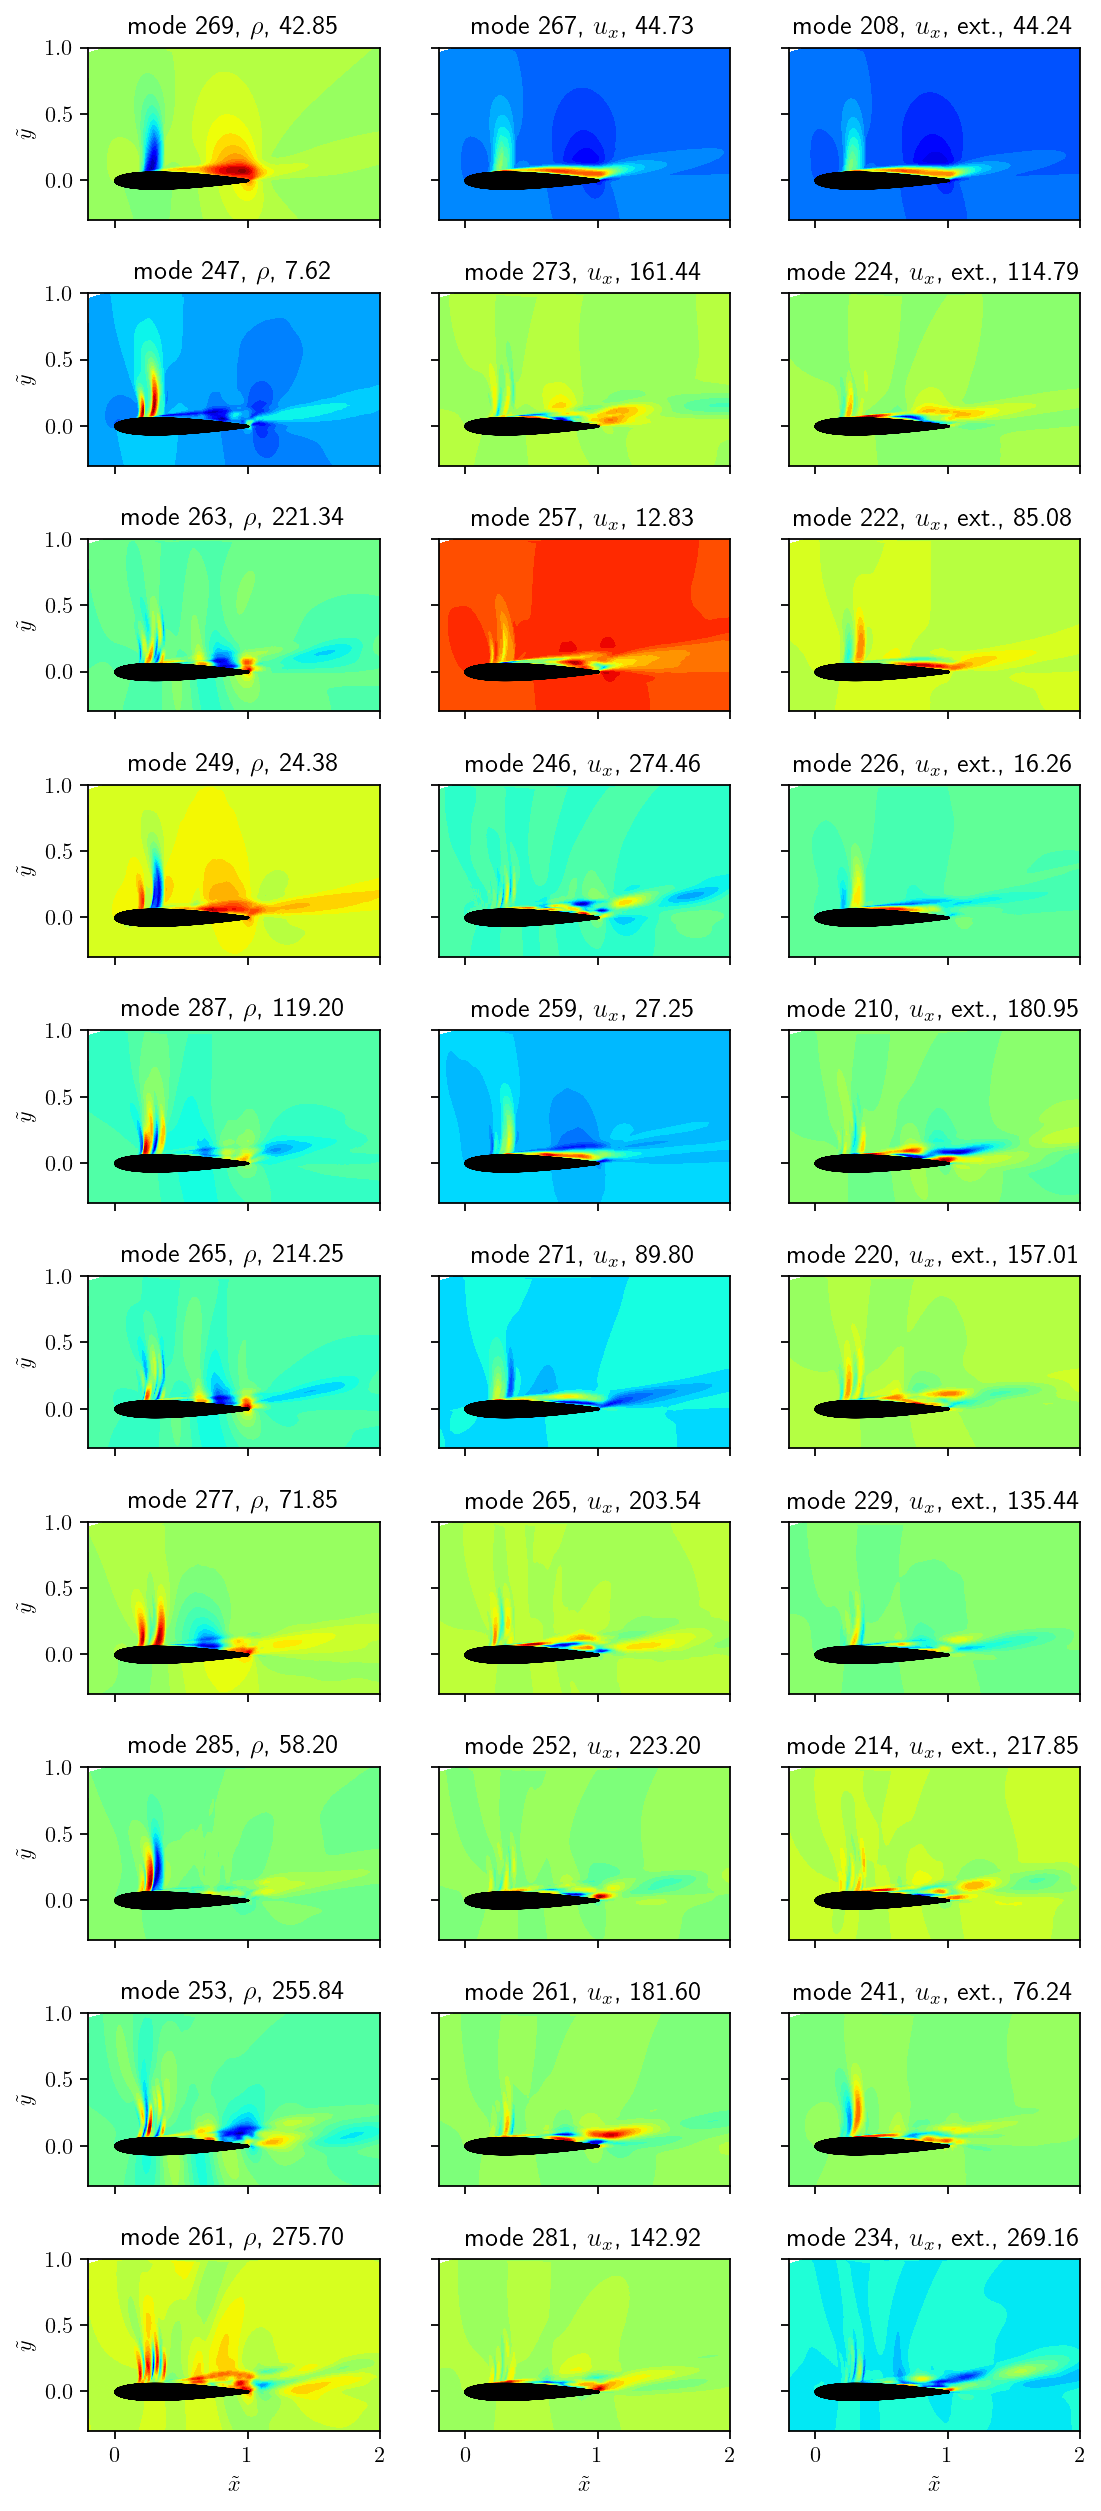

In [70]:
n_modes = 100
rtop = rdmd.top_modes(n_modes, integral=True)
rtop = [m for m in rtop if rdmd.frequency[m] > 1]
vtop = vdmd.top_modes(n_modes, integral=True)
vtop = [m for m in vtop if vdmd.frequency[m] > 1]
avtop = avdmd.top_modes(n_modes, integral=True)
avtop = [m for m in avtop if avdmd.frequency[m] > 1]
print(len(rtop), len(vtop), len(avtop))
n_plot = 10
fig, axarr = plt.subplots(n_plot, 3, figsize=(8, 2*n_plot), sharex=True, sharey=True)

for i, (ri, vi, avi) in enumerate(zip(rtop[:n_plot], vtop[:n_plot], avtop[:n_plot])):
    axarr[i, 0].tricontourf(x, y, rdmd.modes[:, ri].real/volsq, levels=30, cmap="jet")
    axarr[i, 1].tricontourf(x, y, vdmd.modes[:n_points, vi].real/volsq, levels=30, cmap="jet")
    axarr[i, 2].tricontourf(x, y, avdmd.modes[:n_points, avi].real/volsq, levels=30, cmap="jet")
    axarr[i, 0].set_title(f"mode {ri}" + r", $\rho$" + f", {rdmd.frequency[ri]:2.2f}")
    axarr[i, 1].set_title(f"mode {vi}" + r", $u_x$" + f", {vdmd.frequency[vi]:2.2f}")
    axarr[i, 2].set_title(f"mode {avi}" + r", $u_x$, ext." + f", {avdmd.frequency[avi]:2.2f}")
    axarr[i, 0].set_ylabel(r"$\tilde{y}$")
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
        add_naca0012_patch(ax)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

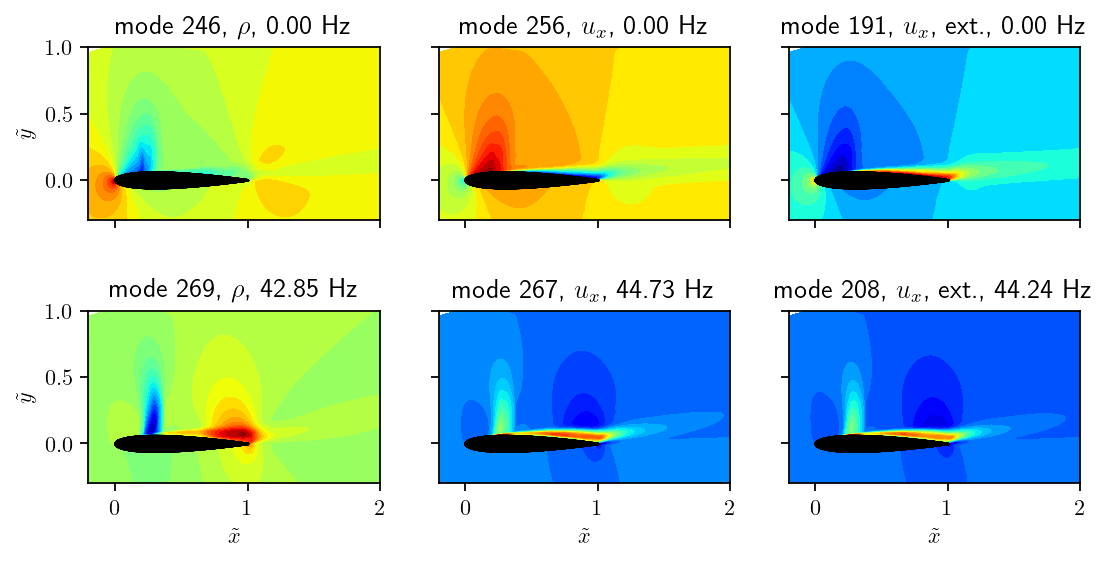

In [74]:
rmodes = (246, 269)
vmodes = (256, 267)
avmodes = (191, 208)
fig, axarr = plt.subplots(len(rmodes), 3, figsize=(8, 2*len(rmodes)), sharex=True, sharey=True)

for i, (ri, vi, avi) in enumerate(zip(rmodes, vmodes, avmodes)):
    axarr[i, 0].tricontourf(x, y, rdmd.modes[:, ri].real/volsq, levels=30, cmap="jet")
    axarr[i, 1].tricontourf(x, y, vdmd.modes[:n_points, vi].real/volsq, levels=30, cmap="jet")
    axarr[i, 2].tricontourf(x, y, avdmd.modes[:n_points, avi].real/volsq, levels=30, cmap="jet")
    axarr[i, 0].set_title(f"mode {ri}" + r", $\rho$" + f", {rdmd.frequency[ri]:2.2f} Hz")
    axarr[i, 1].set_title(f"mode {vi}" + r", $u_x$" + f", {vdmd.frequency[vi]:2.2f} Hz")
    axarr[i, 2].set_title(f"mode {avi}" + r", $u_x$, ext." + f", {avdmd.frequency[avi]:2.2f} Hz")
    axarr[i, 0].set_ylabel(r"$\tilde{y}$")
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
        add_naca0012_patch(ax)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

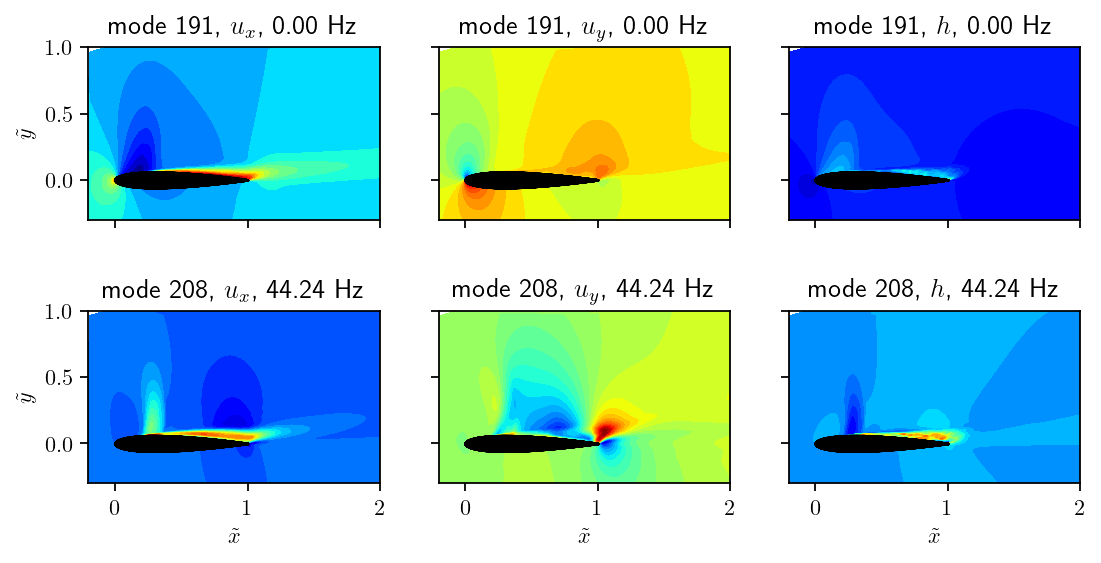

In [77]:
avmodes = (191, 208)
fig, axarr = plt.subplots(len(avmodes), 3, figsize=(8, 2*len(avmodes)), sharex=True, sharey=True)

for i, avi in enumerate(avmodes):
    axarr[i, 0].tricontourf(x, y, avdmd.modes[:n_points, avi].real/volsq, levels=30, cmap="jet")
    axarr[i, 1].tricontourf(x, y, avdmd.modes[n_points:2*n_points, avi].real/volsq, levels=30, cmap="jet")
    axarr[i, 2].tricontourf(x, y, avdmd.modes[2*n_points:, avi].real/volsq, levels=30, cmap="jet")
    axarr[i, 0].set_title(f"mode {avi}" + r", $u_x$" + f", {avdmd.frequency[avi]:2.2f} Hz")
    axarr[i, 1].set_title(f"mode {avi}" + r", $u_y$" + f", {avdmd.frequency[avi]:2.2f} Hz")
    axarr[i, 2].set_title(f"mode {avi}" + r", $h$" + f", {avdmd.frequency[avi]:2.2f} Hz")
    axarr[i, 0].set_ylabel(r"$\tilde{y}$")
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
        add_naca0012_patch(ax)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

In [101]:
def animate_reconstruction(reconstruction, title, n_frames):
    vmin, vmax = reconstruction.min(), reconstruction.max()
    fig, ax = plt.subplots(figsize=(7, 4), dpi=640)
    plt.subplots_adjust(bottom=0.2, top=0.85, left=0.1, right=0.95)
    def animate(i):
        print("\r", f"frame {i:03d}", end="")
        ax.clear()
        tri = ax.tricontourf(x, y, reconstruction[:, i], levels=60, cmap="jet", vmin=vmin, vmax=vmax)
        add_naca0012_patch(ax)
        ax.set_aspect("equal")
        ax.set_xlabel(r"$\tilde{x}$")
        ax.set_ylabel(r"$\tilde{y}$")
        ax.set_title(title)
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
    return FuncAnimation(fig, animate,  frames=n_frames, repeat=True)

In [113]:
writer = FFMpegWriter(fps=60, bitrate=1800)
anim = animate_reconstruction(vdmd.partial_reconstruction({256, 267, 268})[:n_points, ::2]/volsq.unsqueeze(-1), r"buffet mode, $u_x$", times[::2].shape[0])
plt.close()
anim.save(f"{output}naca_dmd_slice_ux_buffet.mp4", writer=writer)

 frame 344

In [112]:
writer = FFMpegWriter(fps=60, bitrate=1800)
anim = animate_reconstruction(
    vdmd.partial_reconstruction({256, 246, 247})[:n_points, ::2]/volsq.unsqueeze(-1),
    r"$u_x$, $\bar{{f}}\approx {:2.2f}$ (${:2.2f} Hz$)".format(normalize_frequency(vdmd.frequency[246]), vdmd.frequency[246]),
    times[::2].shape[0]
)
plt.close()
anim.save(f"{output}naca_dmd_slice_ux_246.mp4", writer=writer)

 frame 344

### Influence of number of snapshots

In [45]:
top_svd = []
top_dmd = []
n_snap = []
for every in range(1, 51):
    print(f"\rEvery {every}", end="")
    dt = (times[1] - times[0]).item() * every
    n_samples = times[::every].shape[0]
    n_snap.append(n_samples)
    svd = SVD(vdm[:, ::every], rank=3)
    f, a = welch(svd.V[:, 1].numpy(), fs=1/dt, nperseg=n_samples, nfft=n_samples)
    amax = np.argmax(a)
    top_svd.append(normalize_frequency(f[amax]))
    dmd = DMD(vdm[:, ::every], dt, optimal=True)
    f = dmd.frequency[dmd.top_modes(2, integral=True)]
    top_dmd.append(normalize_frequency(f[1].abs().item()))

Every 50

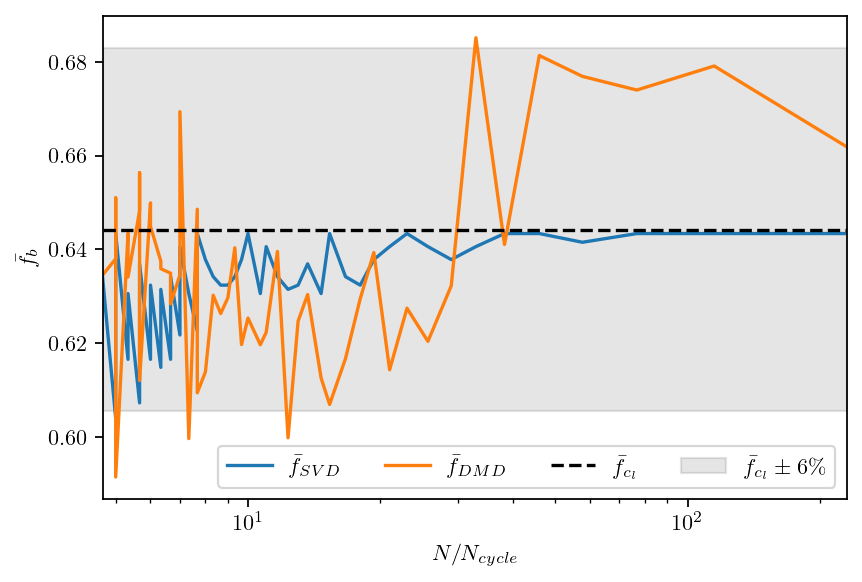

In [66]:
fb = 0.6442
n_snap_b = pt.tensor(n_snap, dtype=pt.float32)/3
plt.plot(n_snap_b, top_svd, label=r"$\bar{f}_{SVD}$")
plt.plot(pt.tensor(n_snap, dtype=pt.float32)/3, top_dmd, label=r"$\bar{f}_{DMD}$")
plt.axhline(fb, ls="--", c="k", label=r"$\bar{f}_{c_l}$")

plt.fill_between(n_snap_b, 0.94*fb, 1.06*fb, alpha=0.1, color="k", label=r"$\bar{f}_{c_l}\pm 6\%$")
plt.legend(ncol=4)
plt.xlabel(r"$N/N_{cycle}$")
plt.ylabel(r"$\bar{f}_b$")
plt.xscale("log")
plt.xlim(n_snap_b[-1], n_snap_b[0])

plt.savefig(output + "naca_slice_n_snap.svg", bbox_inches="tight")
plt.savefig(output + "naca_slice_n_snap.png", bbox_inches="tight")
plt.savefig(output + "naca_slice_n_snap.pdf", bbox_inches="tight")

plt.show()

In [15]:
for end in range(100, 701, 100):
    dt = (times[1] - times[0]).item()
    n_samples = times[:end].shape[0]
    dmd = DMD(vdm[:, :end], dt, optimal=True)
    f = dmd.frequency[dmd.top_modes(3, integral=True)]
    print(end, f)
    print("-"*20)

100 tensor([  0.0000,   0.0000, -77.5723])
--------------------
200 tensor([  0.0000,  48.0000, -48.0000])
--------------------
300 tensor([  0.0000, -35.1028,  35.1028])
--------------------
400 tensor([   0.0000, -139.3377,  139.3377])
--------------------
500 tensor([  0.0000, -45.2180,  45.2180])
--------------------
600 tensor([  0.0000,  45.0532, -45.0532])
--------------------
700 tensor([  0.0000,  44.7305, -44.7305])
--------------------


In [17]:
for end in (230, 460, 690):
    dt = (times[1] - times[0]).item()
    n_samples = times[:end].shape[0]
    dmd = DMD(vdm[:, :end], dt, optimal=True)
    f = dmd.frequency[dmd.top_modes(5, integral=True)]
    print(end, f)
    print("-"*20)

230 tensor([   0.0000,   42.6267,  -42.6267,  139.7473, -139.7473])
--------------------
460 tensor([  0.0000,  20.4347, -20.4347, -44.3453,  44.3453])
--------------------
690 tensor([   0.0000,   44.7305,  -44.7305,  115.0840, -115.0840])
--------------------
